# Modeling channel degradation over time

- https://aiapy.readthedocs.io/en/stable/generated/gallery/instrument_degradation.html

This example demonstrates how to model the degradation
of the AIA channels as a function of time over the entire
lifetime of the instrument.

In [ ]:
from urllib.request import urlretrieve
urlretrieve("https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/response/aia_V10_20201119_190000_response_table.txt", "aia_V10_20201119_190000_response_table.txt");

In [ ]:
import astropy.time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import time_support

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table

# This lets you pass `astropy.time.Time` objects directly to matplotlib
time_support(format="jyear");

The sensitivity of the AIA channels degrade over time. Possible causes include
the deposition of organic molecules from the telescope structure onto the
optical elements and the decrease in detector sensitivity following (E)UV
exposure. When looking at AIA images over the lifetime of the mission, it
is important to understand how the degradation of the instrument impacts the
measured intensity. For monitoring brightness changes over months and years,
degradation correction is an important step in the data normalization process.
For instance, the SDO Machine Learning Dataset
([Galvez et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJS..242....7G/abstract))
includes this correction.

The AIA team models the change in transmission as a function of time (see
[Boerner et al., 2012](https://doi.org/10.1007/s11207-011-9804-8)) and
the table of correction parameters is publicly available via the
[Joint Science Operations Center (JSOC)](http://jsoc.stanford.edu/).

First, fetch this correction table. It is not strictly necessary to do this explicitly,
but will significantly speed up the calculation by only fetching the table
once.



In [ ]:
correction_table = get_correction_table(correction_table='aia_V10_20201119_190000_response_table.txt')

We want to compute the degradation for each EUV channel.

In [ ]:
aia_channels = [94, 131, 171, 193, 211, 304, 335] * u.angstrom

We can use `astropy.time.Time` to create an array of times
between now and the start of the mission with a cadence of one week.

In [ ]:
start_time = astropy.time.Time("2010-03-25T00:00:00", scale="utc")
now = astropy.time.Time.now()
time_range = start_time + np.arange(0, (now - start_time).to(u.day).value, 7) * u.day
len(time_range)

771

In [ ]:
time_range[-1]

<Time object: scale='utc' format='isot' value=2024-12-25T23:59:57.000>

Finally, we can use the `aiapy.calibrate.degradation` function to
compute the degradation for a particular channel and observation time.
This is modeled as the ratio of the effective area measured at a particular
calibration epoch over the uncorrected effective area with a polynomial
interpolation to the exact time.

In [ ]:
degradations = {
    channel: degradation(channel, time_range, correction_table=correction_table) for channel in aia_channels
}

In [ ]:
degradations[94*u.angstrom]

<Quantity [1.000636  , 1.005088  , 1.00954   , 1.013992  , 1.018444  ,
           1.022896  , 1.027348  , 1.0318    , 1.036252  , 1.040704  ,
           1.045156  , 1.049608  , 1.05406   , 1.058512  , 1.062964  ,
           1.067416  , 1.071868  , 1.07632   , 1.080772  , 1.085224  ,
           1.089676  , 1.094128  , 1.09858   , 1.103032  , 1.107484  ,
           1.111936  , 1.116388  , 1.12084   , 1.125292  , 1.129744  ,
           1.134196  , 1.138648  , 1.1431    , 1.147552  , 1.152004  ,
           1.156456  , 1.160908  , 1.16536   , 1.169812  , 1.174264  ,
           1.178716  , 1.183168  , 1.18762   , 1.192072  , 1.196524  ,
           1.1738692 , 1.16288046, 1.15189172, 1.14090297, 1.12991423,
           1.11892548, 1.10793674, 1.09694799, 1.08595925, 1.0749705 ,
           1.06241699, 1.05069923, 1.03898147, 1.02726371, 1.01554594,
           1.00382818, 0.96648612, 0.96975227, 0.97301843, 0.97628458,
           0.97955074, 0.9828169 , 0.98608305, 0.98934921, 0.99261536,
      

Plotting the different degradation curves as a function of time, we can
easily visualize how the different channels have degraded over time.

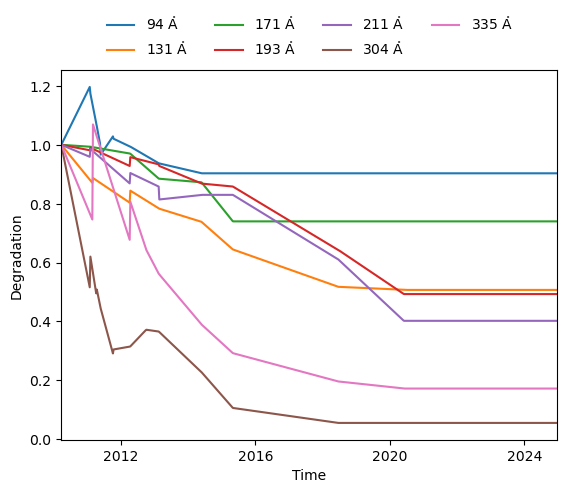

In [ ]:
fig = plt.figure()
ax = fig.gca()

for channel in aia_channels:
    ax.plot(time_range, degradations[channel], label=f"{channel:latex}")

ax.set_xlim(time_range[[0, -1]])
ax.legend(frameon=False, ncol=4, bbox_to_anchor=(0.5, 1), loc="lower center")
ax.set_xlabel("Time")
ax.set_ylabel("Degradation")

plt.show()